# CNN for Spectrogram (3 secs)

## 1 - All 10

In [ ]:
import os
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import models
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Normalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
import matplotlib.pyplot as plt

# Augmentation function
def augment_image(image):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_contrast(image, 0.8, 1.2)
    return image

# Define the genres and file paths
GENRES = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
FILE_PATH = os.path.join('Data', 'spectrograms (3 secs)', 'spectrogram_256')

GENRE_TO_INDEX = {genre: index for index, genre in enumerate(GENRES)}

# Organize data by song ID
song_to_clips = {}

for genre in GENRES:
    genre_dir = os.path.join(FILE_PATH, genre)
    print(f"Processing genre: {genre}")
    for file in os.listdir(genre_dir):
        if not file.endswith(".png"):
            continue
        
        song_id = file.split("_clip_")[0]  # Extract song ID (e.g., "blues.00042")
        
        if song_id not in song_to_clips:
            song_to_clips[song_id] = []

        image = tf.io.read_file(os.path.join(genre_dir, file))
        image = tf.image.decode_png(image, channels=1)
        image = tf.image.convert_image_dtype(image, tf.float32)
        image = tf.image.resize(image, [256, 256])  # Resize to 256x256
        image = augment_image(image)  # Apply augmentation
        image = image.numpy()  # Convert to numpy array
        
        song_to_clips[song_id].append((image, GENRE_TO_INDEX[genre]))

# Convert dictionary to list format
song_ids = list(song_to_clips.keys())
train_ids, test_ids = train_test_split(song_ids, test_size=0.2, random_state=42)

X_train, y_train, X_test, y_test = [], [], [], []

# Assign clips based on the train-test split
for song_id in song_ids:
    clips = song_to_clips[song_id]
    if song_id in train_ids:
        for image, label in clips:
            X_train.append(image)
            y_train.append(label)
    else:
        for image, label in clips:
            X_test.append(image)
            y_test.append(label)

# Convert to numpy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

print(f"Train set: {len(X_train)} samples")
print(f"Test set: {len(X_test)} samples")

# Define the CNN model
model = models.Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 1)),
    Normalization(),
    MaxPooling2D((2, 2)),
    
    Conv2D(64, (3, 3), activation='relu'),
    Normalization(),
    MaxPooling2D((2, 2)),
    
    Conv2D(128, (3, 3), activation='relu'),
    Normalization(),
    MaxPooling2D((2, 2)),
    
    Conv2D(256, (3, 3), activation='relu'),
    Normalization(),
    MaxPooling2D((2, 2)),
    
    Flatten(),
    
    Dense(512, activation='relu'),
    Dropout(0.5),
    
    Dense(256, activation='relu'),
    Dropout(0.5),
    
    Dense(128, activation='relu'), 
    Dense(len(GENRES), activation='softmax')  # Output size matches number of genres
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Learning rate adjustment
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

# Train the model
model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test), batch_size=32, callbacks=[reduce_lr])

# Evaluate the model
evaluation = model.evaluate(X_test, y_test)
print(f"Test accuracy: {evaluation[1]:.3f}")


Processing genre: blues
Processing genre: classical
Processing genre: country
Processing genre: disco
Processing genre: hiphop
Processing genre: jazz
Processing genre: metal
Processing genre: pop
Processing genre: reggae
Processing genre: rock
['blues.00012.3.png', 'blues.00057.3.png', 'blues.00044.9.png', 'blues.00071.0.png', 'blues.00001.9.png', 'blues.00034.0.png', 'blues.00091.5.png', 'blues.00029.5.png', 'blues.00055.1.png', 'blues.00060.8.png', 'blues.00010.1.png', 'blues.00025.8.png', 'blues.00036.2.png', 'blues.00073.2.png', 'blues.00093.7.png', 'blues.00048.4.png', 'blues.00030.4.png', 'blues.00075.4.png', 'blues.00053.7.png', 'blues.00016.7.png', 'blues.00095.1.png', 'blues.00018.8.png', 'blues.00068.1.png', 'blues.00088.4.png', 'blues.00077.6.png', 'blues.00032.6.png', 'blues.00014.5.png', 'blues.00051.5.png', 'blues.00084.9.png', 'blues.00097.3.png', 'blues.00009.0.png', 'blues.00079.9.png', 'blues.00009.1.png', 'blues.00079.8.png', 'blues.00097.2.png', 'blues.00084.8.png',

/Users/conorwoollatt/.pyenv/versions/3.9.6/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 83s 752ms/step - accuracy: 0.2433 - loss: 1.9224 - val_accuracy: 0.4071 - val_loss: 1.5265 - learning_rate: 1.0000e-04
Epoch 2/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 84s 772ms/step - accuracy: 0.2946 - loss: 1.6055 - val_accuracy: 0.4438 - val_loss: 1.3791 - learning_rate: 1.0000e-04
Epoch 3/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 83s 758ms/step - accuracy: 0.3927 - loss: 1.4232 - val_accuracy: 0.5803 - val_loss: 1.1037 - learning_rate: 1.0000e-04
Epoch 4/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 82s 755ms/step - accuracy: 0.4663 - loss: 1.2714 - val_accuracy: 0.6147 - val_loss: 0.9786 - learning_rate: 1.0000e-04
Epoch 5/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 83s 759ms/step - accuracy: 0.5461 - loss: 1.1182 - val_accuracy: 0.5539 - val_loss: 1.0414 - learning_rate: 1.0000e-04
Epoch 6/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 82s 751ms/step - accuracy: 0.5734 - loss: 1.0415 - val_accuracy: 0.6537 - val_loss: 0.8186 - learning_rate: 1.0000e-04
Epoch 7/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 84s 77

## Apply the confusion matrix after the model

63/63 ━━━━━━━━━━━━━━━━━━━━ 16s 244ms/step


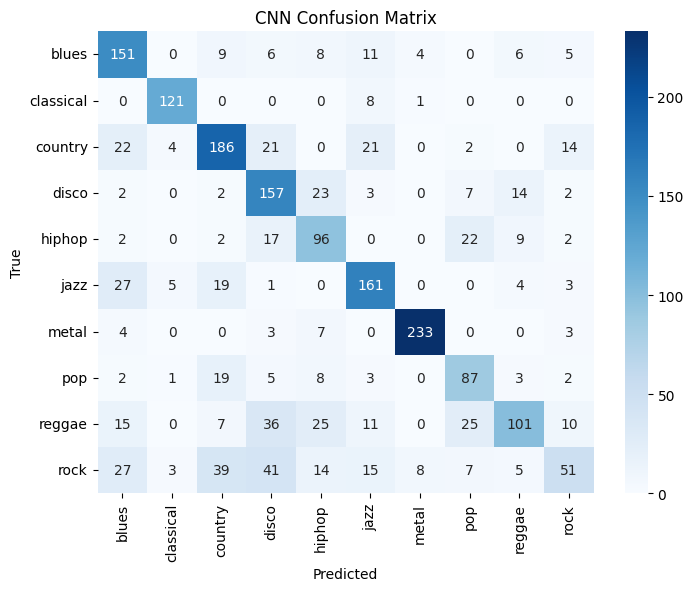

In [2]:
import seaborn as sns
# from sklearn.metrics import confusion
import numpy as NP
from sklearn.metrics import confusion_matrix

cnn_preds = np.argmax(model.predict(X_test), axis=1)
cnn_cm = confusion_matrix(y_test, cnn_preds)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cnn_cm, annot=True, fmt="d", cmap="Blues", xticklabels=GENRES, yticklabels=GENRES)
plt.title("CNN Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

## 2 - Limited Genres Easy (metal and classical)

In [ ]:
import os
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import models
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Normalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
import matplotlib.pyplot as plt

# Augmentation function
def augment_image(image):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_contrast(image, 0.8, 1.2)
    return image

# Define the genres and file paths
GENRES = ['classical', 'metal']
FILE_PATH = os.path.join('Data', 'spectrograms (3 secs)', 'spectrogram_256')

GENRE_TO_INDEX = {genre: index for index, genre in enumerate(GENRES)}

# Organize data by song ID
song_to_clips = {}

for genre in GENRES:
    genre_dir = os.path.join(FILE_PATH, genre)
    print(f"Processing genre: {genre}")
    for file in os.listdir(genre_dir):
        if not file.endswith(".png"):
            continue
        
        song_id = file.split("_clip_")[0]  # Extract song ID (e.g., "blues.00042")
        
        if song_id not in song_to_clips:
            song_to_clips[song_id] = []

        image = tf.io.read_file(os.path.join(genre_dir, file))
        image = tf.image.decode_png(image, channels=1)
        image = tf.image.convert_image_dtype(image, tf.float32)
        image = tf.image.resize(image, [256, 256])  # Resize to 256x256
        image = augment_image(image)  # Apply augmentation
        image = image.numpy()  # Convert to numpy array
        
        song_to_clips[song_id].append((image, GENRE_TO_INDEX[genre]))

# Convert dictionary to list format
song_ids = list(song_to_clips.keys())
train_ids, test_ids = train_test_split(song_ids, test_size=0.2, random_state=42)

X_train, y_train, X_test, y_test = [], [], [], []

# Assign clips based on the train-test split
for song_id in song_ids:
    clips = song_to_clips[song_id]
    if song_id in train_ids:
        for image, label in clips:
            X_train.append(image)
            y_train.append(label)
    else:
        for image, label in clips:
            X_test.append(image)
            y_test.append(label)

# Convert to numpy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

print(f"Train set: {len(X_train)} samples")
print(f"Test set: {len(X_test)} samples")

# Define the CNN model
model = models.Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 1)),
    Normalization(),
    MaxPooling2D((2, 2)),
    
    Conv2D(64, (3, 3), activation='relu'),
    Normalization(),
    MaxPooling2D((2, 2)),
    
    Conv2D(128, (3, 3), activation='relu'),
    Normalization(),
    MaxPooling2D((2, 2)),
    
    Conv2D(256, (3, 3), activation='relu'),
    Normalization(),
    MaxPooling2D((2, 2)),
    
    Flatten(),
    
    Dense(512, activation='relu'),
    Dropout(0.5),
    
    Dense(256, activation='relu'),
    Dropout(0.5),
    
    Dense(128, activation='relu'), 
    Dense(len(GENRES), activation='softmax')  # Output size matches number of genres
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Learning rate adjustment
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

# Train the model
model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test), batch_size=32, callbacks=[reduce_lr])

# Evaluate the model
evaluation = model.evaluate(X_test, y_test)
print(f"Test accuracy: {evaluation[1]:.3f}")


## Confusion Matrix Easy (classical and metal)

In [ ]:
import seaborn as sns
# from sklearn.metrics import confusion
import numpy as NP
from sklearn.metrics import confusion_matrix

cnn_preds = np.argmax(model.predict(X_test), axis=1)
cnn_cm = confusion_matrix(y_test, cnn_preds)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cnn_cm, annot=True, fmt="d", cmap="Blues", xticklabels=GENRES, yticklabels=GENRES)
plt.title("CNN Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

## 3 - Limited genres Hard (disco and pop)

In [ ]:
import os
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import models
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Normalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
import matplotlib.pyplot as plt

# Augmentation function
def augment_image(image):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_contrast(image, 0.8, 1.2)
    return image

# Define the genres and file paths
GENRES = ['disco', 'pop']
FILE_PATH = os.path.join('Data', 'spectrograms (3 secs)', 'spectrogram_256')

GENRE_TO_INDEX = {genre: index for index, genre in enumerate(GENRES)}

# Organize data by song ID
song_to_clips = {}

for genre in GENRES:
    genre_dir = os.path.join(FILE_PATH, genre)
    print(f"Processing genre: {genre}")
    for file in os.listdir(genre_dir):
        if not file.endswith(".png"):
            continue
        
        song_id = file.split("_clip_")[0]  # Extract song ID (e.g., "blues.00042")
        
        if song_id not in song_to_clips:
            song_to_clips[song_id] = []

        image = tf.io.read_file(os.path.join(genre_dir, file))
        image = tf.image.decode_png(image, channels=1)
        image = tf.image.convert_image_dtype(image, tf.float32)
        image = tf.image.resize(image, [256, 256])  # Resize to 256x256
        image = augment_image(image)  # Apply augmentation
        image = image.numpy()  # Convert to numpy array
        
        song_to_clips[song_id].append((image, GENRE_TO_INDEX[genre]))

# Convert dictionary to list format
song_ids = list(song_to_clips.keys())
train_ids, test_ids = train_test_split(song_ids, test_size=0.2, random_state=42)

X_train, y_train, X_test, y_test = [], [], [], []

# Assign clips based on the train-test split
for song_id in song_ids:
    clips = song_to_clips[song_id]
    if song_id in train_ids:
        for image, label in clips:
            X_train.append(image)
            y_train.append(label)
    else:
        for image, label in clips:
            X_test.append(image)
            y_test.append(label)

# Convert to numpy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

print(f"Train set: {len(X_train)} samples")
print(f"Test set: {len(X_test)} samples")

# Define the CNN model
model = models.Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 1)),
    Normalization(),
    MaxPooling2D((2, 2)),
    
    Conv2D(64, (3, 3), activation='relu'),
    Normalization(),
    MaxPooling2D((2, 2)),
    
    Conv2D(128, (3, 3), activation='relu'),
    Normalization(),
    MaxPooling2D((2, 2)),
    
    Conv2D(256, (3, 3), activation='relu'),
    Normalization(),
    MaxPooling2D((2, 2)),
    
    Flatten(),
    
    Dense(512, activation='relu'),
    Dropout(0.5),
    
    Dense(256, activation='relu'),
    Dropout(0.5),
    
    Dense(128, activation='relu'), 
    Dense(len(GENRES), activation='softmax')  # Output size matches number of genres
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Learning rate adjustment
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

# Train the model
model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test), batch_size=32, callbacks=[reduce_lr])

# Evaluate the model
evaluation = model.evaluate(X_test, y_test)
print(f"Test accuracy: {evaluation[1]:.3f}")


## Confusion Matrix Hard (disco and pop)

In [ ]:
import seaborn as sns
# from sklearn.metrics import confusion
import numpy as NP
from sklearn.metrics import confusion_matrix

cnn_preds = np.argmax(model.predict(X_test), axis=1)
cnn_cm = confusion_matrix(y_test, cnn_preds)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cnn_cm, annot=True, fmt="d", cmap="Blues", xticklabels=GENRES, yticklabels=GENRES)
plt.title("CNN Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

## 4 - Limited Genres Medium (5 random)

In [ ]:
import os
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import models
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Normalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
import matplotlib.pyplot as plt
import random

# Augmentation function
def augment_image(image):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_contrast(image, 0.8, 1.2)
    return image

GENRES = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
GENRES = random.sample(GENRES, 5)
print(GENRES)
FILE_PATH = os.path.join('Data', 'spectrograms (3 secs)', 'spectrogram_256')

GENRE_TO_INDEX = {genre: index for index, genre in enumerate(GENRES)}

# Organize data by song ID
song_to_clips = {}

for genre in GENRES:
    genre_dir = os.path.join(FILE_PATH, genre)
    print(f"Processing genre: {genre}")
    for file in os.listdir(genre_dir):
        if not file.endswith(".png"):
            continue
        
        song_id = file.split("_clip_")[0]  # Extract song ID (e.g., "blues.00042")
        
        if song_id not in song_to_clips:
            song_to_clips[song_id] = []

        image = tf.io.read_file(os.path.join(genre_dir, file))
        image = tf.image.decode_png(image, channels=1)
        image = tf.image.convert_image_dtype(image, tf.float32)
        image = tf.image.resize(image, [256, 256])  # Resize to 256x256
        image = augment_image(image)  # Apply augmentation
        image = image.numpy()  # Convert to numpy array
        
        song_to_clips[song_id].append((image, GENRE_TO_INDEX[genre]))

# Convert dictionary to list format
song_ids = list(song_to_clips.keys())
train_ids, test_ids = train_test_split(song_ids, test_size=0.2, random_state=42)

X_train, y_train, X_test, y_test = [], [], [], []

# Assign clips based on the train-test split
for song_id in song_ids:
    clips = song_to_clips[song_id]
    if song_id in train_ids:
        for image, label in clips:
            X_train.append(image)
            y_train.append(label)
    else:
        for image, label in clips:
            X_test.append(image)
            y_test.append(label)

# Convert to numpy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

print(f"Train set: {len(X_train)} samples")
print(f"Test set: {len(X_test)} samples")

# Define the CNN model
model = models.Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 1)),
    Normalization(),
    MaxPooling2D((2, 2)),
    
    Conv2D(64, (3, 3), activation='relu'),
    Normalization(),
    MaxPooling2D((2, 2)),
    
    Conv2D(128, (3, 3), activation='relu'),
    Normalization(),
    MaxPooling2D((2, 2)),
    
    Conv2D(256, (3, 3), activation='relu'),
    Normalization(),
    MaxPooling2D((2, 2)),
    
    Flatten(),
    
    Dense(512, activation='relu'),
    Dropout(0.5),
    
    Dense(256, activation='relu'),
    Dropout(0.5),
    
    Dense(128, activation='relu'), 
    Dense(len(GENRES), activation='softmax')  # Output size matches number of genres
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Learning rate adjustment
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

# Train the model
model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test), batch_size=32, callbacks=[reduce_lr])

# Evaluate the model
evaluation = model.evaluate(X_test, y_test)
print(f"Test accuracy: {evaluation[1]:.3f}")


## Confusion Matrix Medium (5 random)

In [ ]:
import seaborn as sns
# from sklearn.metrics import confusion
import numpy as NP
from sklearn.metrics import confusion_matrix

cnn_preds = np.argmax(model.predict(X_test), axis=1)
cnn_cm = confusion_matrix(y_test, cnn_preds)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cnn_cm, annot=True, fmt="d", cmap="Blues", xticklabels=GENRES, yticklabels=GENRES)
plt.title("CNN Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()